In [1]:
# TEST VERTICAL PROFILES
# WORKING ON FILE 3 TO 8

In [17]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib
import matplotlib.pyplot as plt
import glob

In [2]:
# reading drone's data
path = '/Users/matteo/Documents/Unimib/Drone/Voli_m210_windsensor/'
files = path + 'Oct-12th-2022-*AM-Flight-Airdata.csv'
filesAM = sorted(glob.glob(files))
files = path + 'Oct-12th-2022-*PM-Flight-Airdata.csv'
filesPM = sorted(glob.glob(files))
# metto alla fine il primo file PM (in questo caso temporalemente successivo)
filesPM.append(filesPM[0])
filesPM.pop(0)
drone_files = filesAM + filesPM
drone_files

['/Users/matteo/Documents/Unimib/Drone/Voli_m210_windsensor/Oct-12th-2022-11-34AM-Flight-Airdata.csv',
 '/Users/matteo/Documents/Unimib/Drone/Voli_m210_windsensor/Oct-12th-2022-11-38AM-Flight-Airdata.csv',
 '/Users/matteo/Documents/Unimib/Drone/Voli_m210_windsensor/Oct-12th-2022-11-43AM-Flight-Airdata.csv',
 '/Users/matteo/Documents/Unimib/Drone/Voli_m210_windsensor/Oct-12th-2022-11-51AM-Flight-Airdata.csv',
 '/Users/matteo/Documents/Unimib/Drone/Voli_m210_windsensor/Oct-12th-2022-12-13PM-Flight-Airdata.csv',
 '/Users/matteo/Documents/Unimib/Drone/Voli_m210_windsensor/Oct-12th-2022-12-23PM-Flight-Airdata.csv',
 '/Users/matteo/Documents/Unimib/Drone/Voli_m210_windsensor/Oct-12th-2022-12-27PM-Flight-Airdata.csv',
 '/Users/matteo/Documents/Unimib/Drone/Voli_m210_windsensor/Oct-12th-2022-12-32PM-Flight-Airdata.csv',
 '/Users/matteo/Documents/Unimib/Drone/Voli_m210_windsensor/Oct-12th-2022-12-38PM-Flight-Airdata.csv',
 '/Users/matteo/Documents/Unimib/Drone/Voli_m210_windsensor/Oct-12th-2022

In [3]:
df = pd.concat((pd.read_csv(f) for f in drone_files), ignore_index=True)
df.columns

Index(['time(millisecond)', 'datetime(utc)', 'latitude', 'longitude',
       'height_above_takeoff(meters)',
       'height_above_ground_at_drone_location(meters)',
       'ground_elevation_at_drone_location(meters)',
       'altitude_above_seaLevel(meters)', 'height_sonar(meters)', 'speed(m/s)',
       'distance(meters)', 'mileage(meters)', 'satellites', 'gpslevel',
       'voltage(v)', 'max_altitude(meters)', 'max_ascent(meters)',
       'max_speed(m/s)', 'max_distance(meters)', ' xSpeed(m/s)',
       ' ySpeed(m/s)', ' zSpeed(m/s)', ' compass_heading(degrees)',
       ' pitch(degrees)', ' roll(degrees)', 'isPhoto', 'isVideo',
       'rc_elevator', 'rc_aileron', 'rc_throttle', 'rc_rudder',
       'rc_elevator(percent)', 'rc_aileron(percent)', 'rc_throttle(percent)',
       'rc_rudder(percent)', 'gimbal_heading(degrees)',
       'gimbal_pitch(degrees)', 'battery_percent', 'voltageCell1',
       'voltageCell2', 'voltageCell3', 'voltageCell4', 'voltageCell5',
       'voltageCell6', 'curr

In [4]:
# select columns
df_drone = df[['datetime(utc)', 'latitude', 'longitude', ' xSpeed(m/s)', ' ySpeed(m/s)', ' zSpeed(m/s)', 'ascent(meters)']].copy()
df_drone['datetime(utc)'] = pd.to_datetime(df_drone['datetime(utc)'], format='%Y-%m-%d %H:%M:%S') #+ pd.to_timedelta(df_drone.groupby(['datetime(utc)']).cumcount()*100, unit='ms')
df_drone.dtypes

datetime(utc)     datetime64[ns]
latitude                 float64
longitude                float64
 xSpeed(m/s)             float64
 ySpeed(m/s)             float64
 zSpeed(m/s)             float64
ascent(meters)           float64
dtype: object

In [5]:
# average over second
df_drone_ave = df_drone.groupby(['datetime(utc)']).mean().reset_index()
df_drone_ave['datetime(utc)'][0]

Timestamp('2022-10-12 09:34:56')

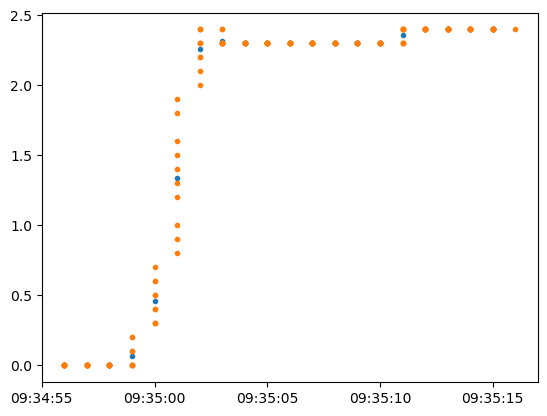

In [6]:
# ascent variability over time
plt.plot(df_drone_ave['datetime(utc)'][0:20], df_drone_ave['ascent(meters)'][0:20],'.')
plt.plot(df_drone['datetime(utc)'][0:200], df_drone['ascent(meters)'][0:200],'.')

In [7]:
# reading sensor data
path = '/Users/matteo/Documents/Unimib/Drone/Sparvio_sensor/file_3-8/'
files = path + '20221012_*.csv'
sparvio_files = sorted(glob.glob(files))
# sparvio_files = [path + '20221012_093834.csv', path + '20221012_094245.csv']
df_s = pd.concat((pd.read_csv(f, sep=';',skiprows=9) for f in sparvio_files), ignore_index=True)
df_s['Time (UTC)'] = '2022-10-12 ' + df_s['Time (UTC)']
df_s['Time (UTC)'] = pd.to_datetime(df_s['Time (UTC)'], format='%Y-%m-%d %H:%M:%S').dt.floor('s')
df_s_ave = df_s.groupby(['Time (UTC)']).mean().reset_index()
df_s_std = df_s.groupby(['Time (UTC)']).std().reset_index()
df_s_ave['Time (UTC)'][0]

Timestamp('2022-10-12 09:38:34')

In [8]:
df_s_ave.columns

Index(['Time (UTC)', ' C.wspd', ' C.wdir', ' C.windU', ' C.windV', ' C.windW',
       ' C.temp', ' C.rh', ' C.pr', ' C.pitch', ' C.roll', ' C.heading'],
      dtype='object')

In [9]:
df_s.groupby(['Time (UTC)']).count()[' C.wspd'].value_counts()

5    2403
2       5
4       2
3       2
1       1
Name:  C.wspd, dtype: int64

In [8]:
df_merged = df_s_ave.merge(df_drone_ave, how='inner', left_on='Time (UTC)', right_on='datetime(utc)')
df_merged_std = df_s_std.merge(df_drone_ave, how='inner', left_on='Time (UTC)', right_on='datetime(utc)')

In [9]:
arr = np.diff(df_merged['ascent(meters)'])
arr = np.insert(arr, 0, 0, axis=0)
df_merged['elevation_gain(meters)'] = pd.Series(arr)

arr = np.diff(df_merged_std['ascent(meters)'])
arr = np.insert(arr, 0, 0, axis=0)
df_merged_std['elevation_gain(meters)'] = pd.Series(arr)

In [12]:
df_merged['ascent(meters)']

0       0.000000
1       0.000000
2       0.000000
3       0.066667
4       0.290000
          ...   
2079    1.036364
2080    0.450000
2081    0.070000
2082    0.000000
2083    0.000000
Name: ascent(meters), Length: 2084, dtype: float64

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text major ticklabel objects>)

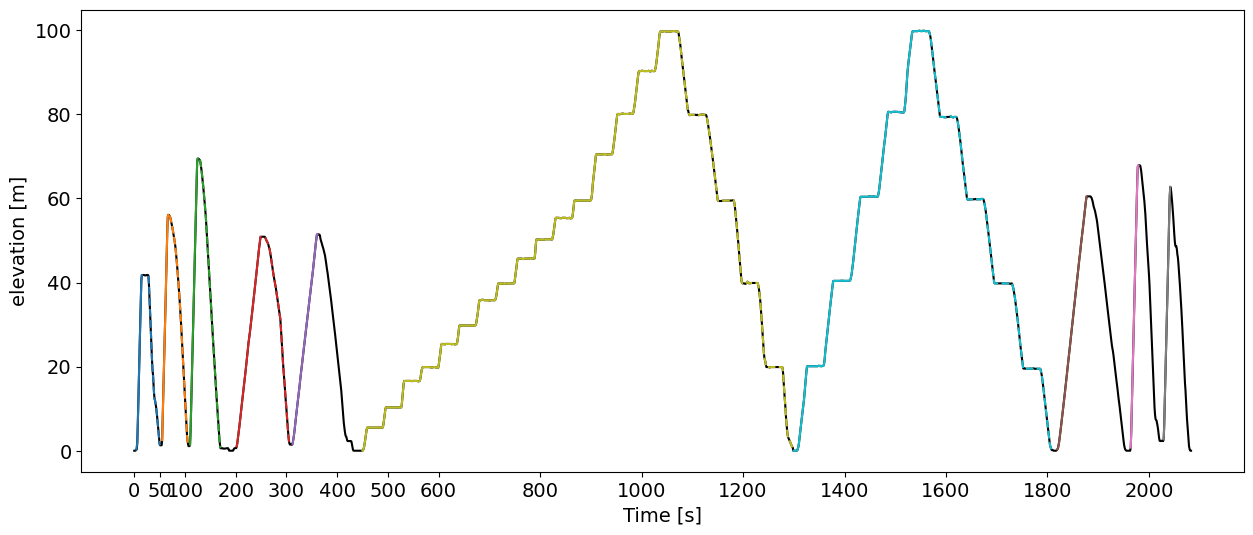

In [15]:
# select ascents' runs
fig = plt.figure(figsize=(15,6))

df_merged['ascent(meters)'].plot(color='black')

# --- UP 1 --- 
df_tmp = df_merged.iloc[:50]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up1 = df_tmp.copy(); df_up1['ascent(meters)'].plot()
# same df but for std
df_tmp = df_merged_std.iloc[:50]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up1_std = df_tmp.copy()

# --- DOWN 1 --- 
df_tmp = df_merged.iloc[:60]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] < -0.1]
df_down1 = df_tmp.copy(); df_down1['ascent(meters)'].plot(style='--', color='C0')
# same df but for std
df_tmp = df_merged_std.iloc[:60]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] < -0.1]
df_down1_std = df_tmp.copy()

# --- UP 2 --- 
df_tmp = df_merged.iloc[50:100]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up2 = df_tmp.copy(); df_up2['ascent(meters)'].plot()
# same df but for std
df_tmp = df_merged_std.iloc[50:100]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up2_std = df_tmp.copy()

# --- DOWN 2 --- 
df_tmp = df_merged.iloc[60:110]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] < -0.1]
df_down2 = df_tmp.copy(); df_down2['ascent(meters)'].plot(style='--', color='C1')
# same df but for std
df_tmp = df_merged_std.iloc[60:110]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] < -0.1]
df_down2_std = df_tmp.copy()

# --- UP 3 --- 
df_tmp = df_merged.iloc[100:150]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up3 = df_tmp.copy(); df_up3['ascent(meters)'].plot()
# same df but for std
df_tmp = df_merged_std.iloc[100:150]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up3_std = df_tmp.copy()

# --- DOWN 3 --- 
df_tmp = df_merged.iloc[120:180]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] < -0.1]
df_down3 = df_tmp.copy(); df_down3['ascent(meters)'].plot(style='--', color='C2')
# same df but for std
df_tmp = df_merged_std.iloc[120:180]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] < -0.1]
df_down3_std = df_tmp.copy()

# --- UP 4 --- 
df_tmp = df_merged.iloc[200:300]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up4 = df_tmp.copy(); df_up4['ascent(meters)'].plot()
# same df but for std
df_tmp = df_merged_std.iloc[200:300]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up4_std = df_tmp.copy()

# --- DOWN 4 --- 
df_tmp = df_merged.iloc[220:320]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] < -0.1]
df_down4 = df_tmp.copy(); df_down4['ascent(meters)'].plot(style='--', color='C3')

# --- UP 5 --- 
df_tmp = df_merged.iloc[300:370]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up5 = df_tmp.copy(); df_up5['ascent(meters)'].plot()
# same df but for std
df_tmp = df_merged_std.iloc[300:370]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up5_std = df_tmp.copy()

# --- UP 6 --- 
df_tmp = df_merged.iloc[1800:1900]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up6 = df_tmp.copy(); df_up6['ascent(meters)'].plot()
# same df but for std
df_tmp = df_merged_std.iloc[1800:1900]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up6_std = df_tmp.copy()

# --- UP 7 --- 
df_tmp = df_merged.iloc[1900:2000]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up7 = df_tmp.copy(); df_up7['ascent(meters)'].plot()
# same df but for std
df_tmp = df_merged_std.iloc[1900:2000]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up7_std = df_tmp.copy()

# --- UP 8 --- 
df_tmp = df_merged.iloc[2010:]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up8 = df_tmp.copy(); df_up8['ascent(meters)'].plot()
# same df but for std
df_tmp = df_merged_std.iloc[2010:]
df_tmp = df_tmp.loc[df_tmp['elevation_gain(meters)'] > 0.1]
df_up8_std = df_tmp.copy()

# --- GRAD 1 --- 
df_tmp = df_merged.iloc[450:1060]
df_grad1 = df_tmp.copy(); df_grad1['ascent(meters)'].plot()
# same df but for std
df_tmp = df_merged_std.iloc[450:1060]
df_grad1_std = df_tmp.copy()

# --- GRAD 1 DOWN --- 
df_tmp = df_merged.iloc[1060:1300]
df_grad1D = df_tmp.copy(); df_grad1D['ascent(meters)'].plot(style='--', color='C8')
# same df but for std
df_tmp = df_merged_std.iloc[1060:1300]
df_grad1D_std = df_tmp.copy()

# --- GRAD 2 --- 
df_tmp = df_merged.iloc[1300:1560]
df_grad2 = df_tmp.copy(); df_grad2['ascent(meters)'].plot()
# same df but for std
df_tmp = df_merged_std.iloc[1300:1560]
df_grad2_std = df_tmp.copy()

# --- GRAD 2 DOWN --- 
df_tmp = df_merged.iloc[1560:1810]
df_grad2D = df_tmp.copy(); df_grad2D['ascent(meters)'].plot(style='--', color='C9')
# same df but for std
df_tmp = df_merged_std.iloc[1560:1810]
df_grad2D_std = df_tmp.copy()

plt.xlabel('Time [s]', fontsize=14); plt.ylabel('elevation [m]', fontsize=14)

xticks = np.asarray(list(np.arange(0,150,50)) + list(np.arange(200,600,100)) + list(np.arange(600,2200,200)))
plt.xticks(xticks, fontsize=14)
plt.yticks(fontsize=14)


# df_up1 = df_up1.reset_index(); df_up2 = df_up2.reset_index(); df_up3 = df_up3.reset_index()
# df_up4 = df_up4.reset_index(); df_up5 = df_up5.reset_index()

(0.0, 70.0)

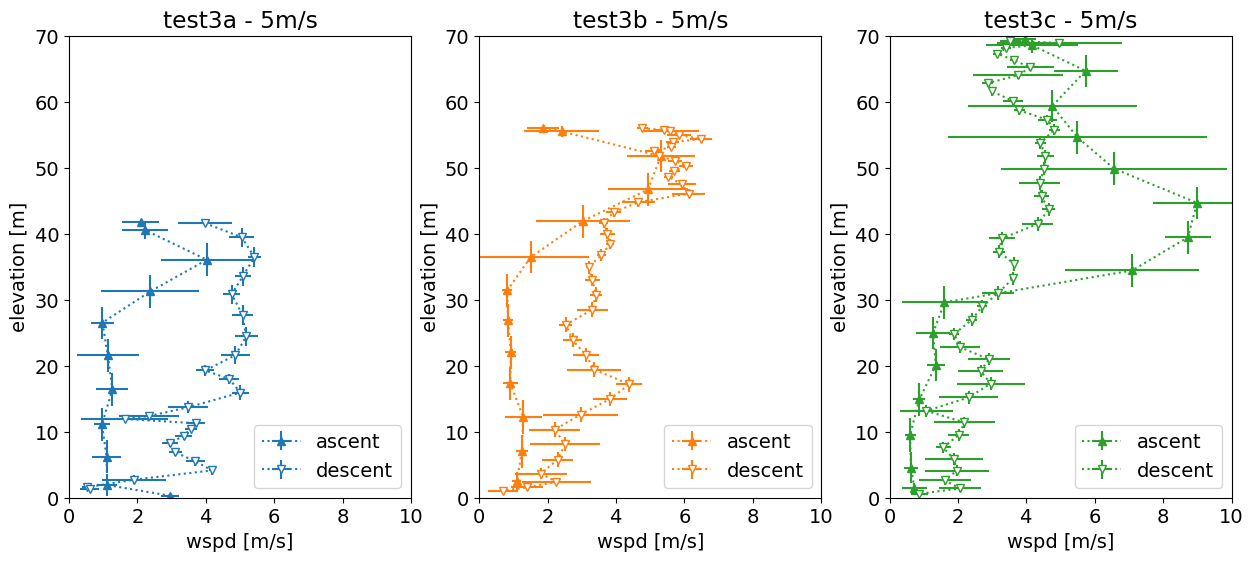

In [25]:
# FIGURA TRE PANNELLI, OGNI PANNELLO SALITA vs DISCESA STESSO COLORE es. triangoli su/giu
fig = plt.figure(figsize=(15,6))

font = {'size'   : 14}
matplotlib.rc('font', **font)

ax = plt.subplot(131)
plt.errorbar(df_up1[' C.wspd'], df_up1['ascent(meters)'], xerr=df_up1_std[' C.wspd'], yerr=df_up1[' zSpeed(m/s)']/2., fmt='^:', label='ascent', color='C0')
plt.errorbar(df_down1[' C.wspd'], df_down1['ascent(meters)'], xerr=df_down1_std[' C.wspd'], yerr=df_down1[' zSpeed(m/s)']/2., fmt='v:', mfc='w', label='descent', color='C0')
plt.legend(loc='lower right', fontsize=14); plt.xlabel('wspd [m/s]'); plt.ylabel('elevation [m]')
plt.title('test3a - 5m/s')
plt.xlim(0,10); plt.ylim(0,70)
ax = plt.subplot(132)
plt.errorbar(df_up2[' C.wspd'], df_up2['ascent(meters)'], xerr=df_up2_std[' C.wspd'], yerr=df_up2[' zSpeed(m/s)']/2., fmt='^:', label='ascent', color='C1')
plt.errorbar(df_down2[' C.wspd'], df_down2['ascent(meters)'], xerr=df_down2_std[' C.wspd'], yerr=df_down2[' zSpeed(m/s)']/2., fmt='v:', mfc='w', label='descent', color='C1')
plt.legend(loc='lower right', fontsize=14); plt.xlabel('wspd [m/s]'); plt.ylabel('elevation [m]')
plt.title('test3b - 5m/s')
plt.xlim(0,10); plt.ylim(0,70)
ax = plt.subplot(133)
plt.errorbar(df_up3[' C.wspd'], df_up3['ascent(meters)'], xerr=df_up3_std[' C.wspd'], yerr=df_up3[' zSpeed(m/s)']/2., fmt='^:', label='ascent', color='C2')
plt.errorbar(df_down3[' C.wspd'], df_down3['ascent(meters)'], xerr=df_down3_std[' C.wspd'], yerr=df_down3[' zSpeed(m/s)']/2., fmt='v:', mfc='w', label='descent', color='C2')
plt.legend(loc='lower right', fontsize=14); plt.xlabel('wspd [m/s]'); plt.ylabel('elevation [m]')
plt.title('test3c - 5m/s')
plt.xlim(0,10); plt.ylim(0,70)

(0.0, 70.0)

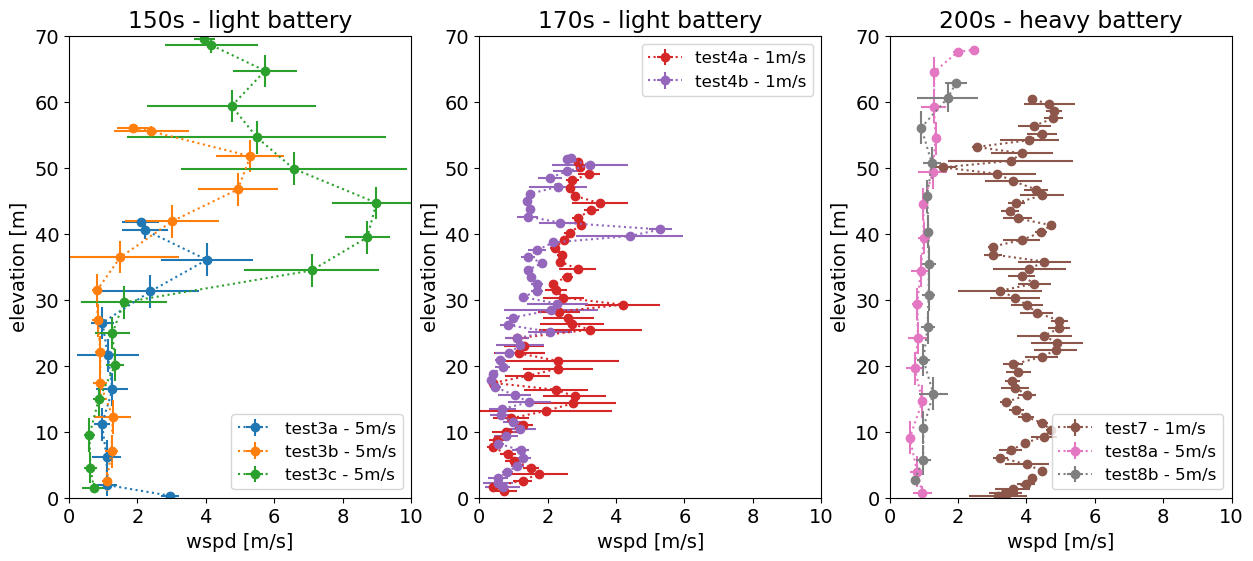

In [31]:
# plot vertical profile of wind
fig = plt.figure(figsize=(15,6))

font = {'size'   : 14}
matplotlib.rc('font', **font)

ax = plt.subplot(131)
plt.errorbar(df_up1[' C.wspd'], df_up1['ascent(meters)'], xerr=df_up1_std[' C.wspd'], yerr=df_up1[' zSpeed(m/s)']/2., fmt='o:', label='test3a - 5m/s', color='C0')
plt.errorbar(df_up2[' C.wspd'], df_up2['ascent(meters)'], xerr=df_up2_std[' C.wspd'], yerr=df_up2[' zSpeed(m/s)']/2., fmt='o:', label='test3b - 5m/s', color='C1')
plt.errorbar(df_up3[' C.wspd'], df_up3['ascent(meters)'], xerr=df_up3_std[' C.wspd'], yerr=df_up3[' zSpeed(m/s)']/2., fmt='o:', label='test3c - 5m/s', color='C2')
plt.legend(loc='lower right', fontsize=12); plt.xlabel('wspd [m/s]'); plt.ylabel('elevation [m]')
plt.title('150s - light battery')
plt.xlim(0,10); plt.ylim(0,70)
ax = plt.subplot(132)
plt.errorbar(df_up4[' C.wspd'], df_up4['ascent(meters)'], xerr=df_up4_std[' C.wspd'], yerr=df_up4[' zSpeed(m/s)']/2., fmt='o:', label='test4a - 1m/s', color='C3')
plt.errorbar(df_up5[' C.wspd'], df_up5['ascent(meters)'], xerr=df_up5_std[' C.wspd'], yerr=df_up5[' zSpeed(m/s)']/2., fmt='o:', label='test4b - 1m/s', color='C4')
plt.legend(fontsize=12); plt.xlabel('wspd [m/s]'); plt.ylabel('elevation [m]')
plt.title('170s - light battery')
plt.xlim(0,10); plt.ylim(0,70)
ax = plt.subplot(133)
plt.errorbar(df_up6[' C.wspd'], df_up6['ascent(meters)'], xerr=df_up6_std[' C.wspd'], yerr=df_up6[' zSpeed(m/s)']/2., fmt='o:', label='test7 - 1m/s', color='C5')
plt.errorbar(df_up7[' C.wspd'], df_up7['ascent(meters)'], xerr=df_up7_std[' C.wspd'], yerr=df_up7[' zSpeed(m/s)']/2., fmt='o:', label='test8a - 5m/s', color='C6')
plt.errorbar(df_up8[' C.wspd'], df_up8['ascent(meters)'], xerr=df_up8_std[' C.wspd'], yerr=df_up8[' zSpeed(m/s)']/2., fmt='o:', label='test8b - 5m/s', color='C7')

# plt.plot(df_grad1[' C.wspd'], df_grad1['ascent(meters)'], 'o', label='grad1 - 1m/s', color='C8')
# plt.plot(df_grad2[' C.wspd'], df_grad2['ascent(meters)'], 'o', label='grad2 - 1m/s - heavy', color='C9')
plt.legend(fontsize=12); plt.xlabel('wspd [m/s]'); plt.ylabel('elevation [m]')
plt.title('200s - heavy battery')
plt.xlim(0,10); plt.ylim(0,70)

In [126]:
# # light battery left - heavy battery right
# fig = plt.figure(figsize=(15,6))

# ax = plt.subplot(121)
# plt.plot(df_up1[' C.wspd'], df_up1['ascent(meters)'], 'o-', label='run1 - 5m/s', color='C0')
# plt.plot(df_up2[' C.wspd'], df_up2['ascent(meters)'], 'o-', label='run2 - 5m/s', color='C1')
# plt.plot(df_up3[' C.wspd'], df_up3['ascent(meters)'], 'o-', label='run3 - 5m/s', color='C2')
# plt.plot(df_up4[' C.wspd'], df_up4['ascent(meters)'], 'o-', label='run1 - 1m/s', color='C3')
# plt.plot(df_up5[' C.wspd'], df_up5['ascent(meters)'], 'o-', label='run2 - 1m/s', color='C4')
# plt.legend(); plt.xlabel('wspd [m/s]'); plt.ylabel('elevation [m]')
# ax = plt.subplot(122)
# plt.plot(df_up6[' C.wspd'], df_up6['ascent(meters)'], 'o-', label='run1 - 1m/s - heavy', color='C5')
# plt.plot(df_up7[' C.wspd'], df_up7['ascent(meters)'], 'o-', label='run4 - 5m/s - heavy', color='C6')
# plt.plot(df_up8[' C.wspd'], df_up8['ascent(meters)'], 'o-', label='run5 - 5m/s - heavy', color='C7')
# plt.legend(); plt.xlabel('wspd [m/s]'); plt.ylabel('elevation [m]')

-0.10000000000000142


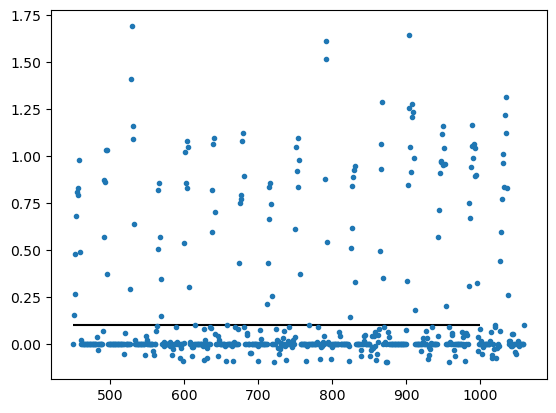

In [92]:
print(df_grad1['elevation_gain(meters)'].min())
plt.plot(df_grad1['elevation_gain(meters)'], '.')
plt.hlines(0.1,450,1000)

In [11]:
# GRAD 1 - mean when not moving
df_tmp = df_grad1.loc[df_grad1['elevation_gain(meters)'] < 0.1]
# df_grad1_steady = df_tmp.copy().reset_index()
df_tmp['ascent(meters)'] = df_tmp['ascent(meters)'].astype('int')
df_grad1_steady = df_tmp.groupby(['ascent(meters)']).mean().reset_index()
df_grad1_steady_std = df_tmp.groupby(['ascent(meters)']).std().reset_index()

# GRAD 1 - data when moving up
df_tmp = df_grad1.loc[df_grad1['elevation_gain(meters)'] > 0.1]
df_grad1_up = df_tmp.copy()
df_tmp = df_grad1_std.loc[df_grad1_std['elevation_gain(meters)'] > 0.1]
df_grad1_up_std = df_tmp.copy()

# GRAD 1 DOWN - mean when not moving
df_tmp = df_grad1D.loc[np.abs(df_grad1D['elevation_gain(meters)']) < 0.1]
df_tmp['ascent(meters)'] = df_tmp['ascent(meters)'].astype('int')
df_grad1D_steady = df_tmp.groupby(['ascent(meters)']).mean().reset_index()
df_grad1D_steady_std = df_tmp.groupby(['ascent(meters)']).std().reset_index()

# GRAD 1 DOWN - data when moving down
df_tmp = df_grad1D.loc[df_grad1D['elevation_gain(meters)'] < -0.1]
df_grad1D_down = df_tmp.copy()
df_tmp = df_grad1D_std.loc[df_grad1D_std['elevation_gain(meters)'] < -0.1]
df_grad1D_down_std = df_tmp.copy()

/Applications/miniconda3/envs/drone/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/miniconda3/envs/drone/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'descent')

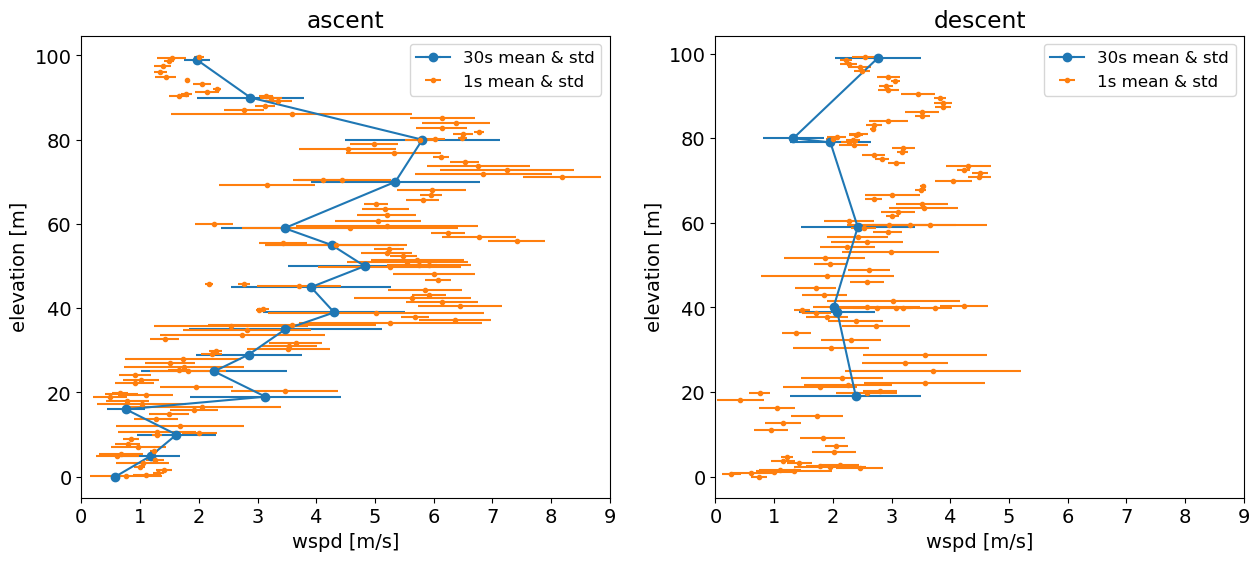

In [30]:
fig = plt.figure(figsize=(15,6))

font = {'size'   : 14}
matplotlib.rc('font', **font)

ax = plt.subplot(121)
plt.errorbar(df_grad1_steady[' C.wspd'], df_grad1_steady['ascent(meters)'], xerr=df_grad1_steady_std[' C.wspd'], fmt='o-', label='30s mean & std')
plt.errorbar(df_grad1_up[' C.wspd'], df_grad1_up['ascent(meters)'], xerr=df_grad1_up_std[' C.wspd'], fmt='.', label='1s mean & std')
plt.xlabel('wspd [m/s]'); plt.ylabel('elevation [m]'); plt.legend(fontsize=12)
plt.xlim(0,9)
plt.title('ascent')

ax = plt.subplot(122)
plt.errorbar(df_grad1D_steady[' C.wspd'], df_grad1D_steady['ascent(meters)'], xerr=df_grad1D_steady_std[' C.wspd'], fmt='o-', label='30s mean & std')
plt.errorbar(df_grad1D_down[' C.wspd'], df_grad1D_down['ascent(meters)'], xerr=df_grad1D_down_std[' C.wspd'], fmt='.', label='1s mean & std')
plt.xlabel('wspd [m/s]'); plt.ylabel('elevation [m]'); plt.legend(fontsize=12)
plt.xlim(0,9)
plt.title('descent')

In [23]:
# GRAD 2 - mean when not moving
df_tmp = df_grad2.loc[df_grad2['elevation_gain(meters)'] < 0.1]
# df_grad1_steady = df_tmp.copy().reset_index()
df_tmp['ascent(meters)'] = df_tmp['ascent(meters)'].astype('int')
df_grad2_steady = df_tmp.groupby(['ascent(meters)']).mean().reset_index()
df_grad2_steady_std = df_tmp.groupby(['ascent(meters)']).std().reset_index()

# GRAD 2 - data when moving up
df_tmp = df_grad2.loc[df_grad2['elevation_gain(meters)'] > 0.1]
df_grad2_up = df_tmp.copy()
df_tmp = df_grad2_std.loc[df_grad2['elevation_gain(meters)'] > 0.1]
df_grad2_up_std = df_tmp.copy()

# GRAD 2 DOWN - mean when not moving
df_tmp = df_grad2D.loc[np.abs(df_grad2D['elevation_gain(meters)']) < 0.1]
df_tmp['ascent(meters)'] = df_tmp['ascent(meters)'].astype('int')
df_grad2D_steady = df_tmp.groupby(['ascent(meters)']).mean().reset_index()
df_grad2D_steady_std = df_tmp.groupby(['ascent(meters)']).std().reset_index()

# GRAD 2 DOWN - data when moving down
df_tmp = df_grad2D.loc[df_grad2D['elevation_gain(meters)'] < -0.1]
df_grad2D_down = df_tmp.copy()
df_tmp = df_grad2D_std.loc[df_grad2D_std['elevation_gain(meters)'] < -0.1]
df_grad2D_down_std = df_tmp.copy()

/Applications/miniconda3/envs/drone/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/miniconda3/envs/drone/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'descent')

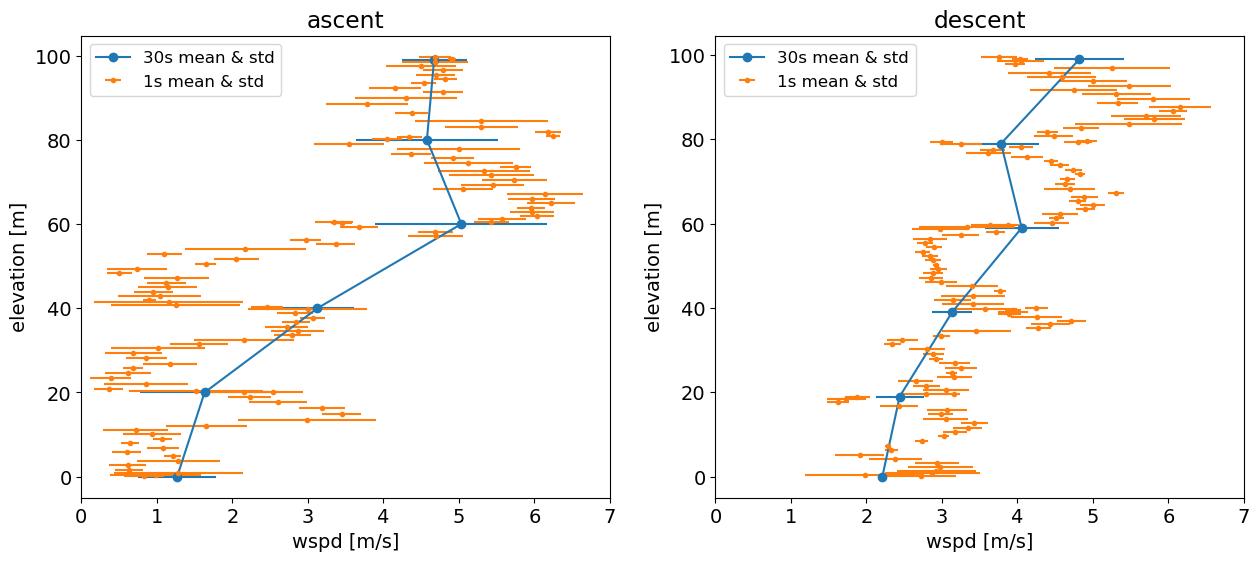

In [29]:
fig = plt.figure(figsize=(15,6))

font = {'size'   : 14}
matplotlib.rc('font', **font)

ax = plt.subplot(121)
plt.errorbar(df_grad2_steady[' C.wspd'], df_grad2_steady['ascent(meters)'], xerr=df_grad2_steady_std[' C.wspd'], fmt='o-', label='30s mean & std')
plt.errorbar(df_grad2_up[' C.wspd'], df_grad2_up['ascent(meters)'], xerr=df_grad2_up_std[' C.wspd'], fmt='.', label='1s mean & std')
plt.xlabel('wspd [m/s]'); plt.ylabel('elevation [m]'); plt.legend(fontsize=12)
plt.xlim(0,7)
plt.title('ascent')

ax = plt.subplot(122)
plt.errorbar(df_grad2D_steady[' C.wspd'], df_grad2D_steady['ascent(meters)'], xerr=df_grad2D_steady_std[' C.wspd'], fmt='o-', label='30s mean & std')
plt.errorbar(df_grad2D_down[' C.wspd'], df_grad2D_down['ascent(meters)'], xerr=df_grad2D_down_std[' C.wspd'], fmt='.', label='1s mean & std')
plt.xlabel('wspd [m/s]'); plt.ylabel('elevation [m]'); plt.legend(fontsize=12)
plt.xlim(0,7)
plt.title('descent')